<a href="https://colab.research.google.com/github/Gaurang-1402/RV-final-project/blob/main/monocular-depth-estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Step 0: Creating a Data loader

In [123]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import glob
import numpy as np
from torch.utils.data import random_split


In [124]:
class MonocularDepthDataset(Dataset):
    def __init__(self, data_path, transforms_rgb=None, transforms_depth=None):
        self.data_path = data_path
        self.transforms_rgb = transforms_rgb
        self.transforms_depth = transforms_depth

        for folder in sorted(glob.glob(os.path.join(data_path, "*"))):
            self.rgb_filenames = sorted(glob.glob(os.path.join(folder, "rgb_*.jpg")))
            self.depth_filenames = sorted(glob.glob(os.path.join(folder, "sync_depth_*.png")))

    def __getitem__(self, index):
        rgb = Image.open(self.rgb_filenames[index])
        depth = Image.open(self.depth_filenames[index])

        if self.transforms_rgb:
            rgb = self.transforms_rgb(rgb)

        if self.transforms_depth:
            # Convert depth image to float
            depth = np.array(depth).astype(np.float32)
            depth = Image.fromarray(depth)

            depth = self.transforms_depth(depth)

        return rgb, depth

    def __len__(self):
        return len(self.rgb_filenames)


### Data Augmentation

TODO confirm if we should do since dataset is big enough

Next, we will do data augmentation. DL models are data hungry. A good trick to increse the size of dataset without the hardwork of acquiring/labeling more data is data augmentation. 

For each training image we will randomly rotate it (by up to 5 degrees), flip/mirror with probability 0.5, shift by +/-1 pixel. 

In [125]:
...

Ellipsis

### Normalization and Standardization

To put it simple:

***normalize***: making your data range in [0, 1]

**standardize**: making your data's mean=0 and std=1

In modern deep learning, sometimes it's often okay if you don't do these, but they will often help with faster training and better accuracy. Please see this [article](https://stats.stackexchange.com/questions/185853/why-do-we-need-to-normalize-the-images-before-we-put-them-into-cnn).

Calculate the mean and standard deviation of pixel values so we can standardize the dataset later. 


TODO: remove hardcoded values and calculate mean and std

train_dataset = train_dataset.data.float()
means = train_dataset.data.mean(axis = (0)) / 255
stds = train_dataset.data.std(axis = (0)) / 255

In [126]:

# Define transformations for the RGB images
transform_rgb = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define transformations for the depth images
transform_depth = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Create an instance of the dataset
depth_dataset = MonocularDepthDataset(data_path="../dataset/sync/", transforms_rgb=transform_rgb, transforms_depth=transform_depth)


In [127]:
# # Create a DataLoader object
# depth_dataloader = DataLoader(depth_dataset, batch_size=32, shuffle=True)

# # Iterate over the DataLoader object to get batches of data for training the model
# for rgb, depth in depth_dataloader:
#     # TODO train the model
#     ...

### Data Loading and Pre-processing

Leave out 10% of data from the training set as the validation set. **The model won't train on the validation set, but only do inference on it.** 

Validation set is similar to test set (hence the similar transformations), but it's a good practice to only run your model on test set for only **once**, and use your validation set as a gauge of how well your model generalize while tweaking hyper-parameters

In [128]:

# Determine the split ratios
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Calculate the number of samples for each split
total_samples = len(depth_dataset)
train_samples = int(train_ratio * total_samples)
val_samples = int(val_ratio * total_samples)
test_samples = total_samples - train_samples - val_samples

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(depth_dataset, [train_samples, val_samples, test_samples])


The final step is to create a DataLoader object. 

DataLoader object can be thought of as an iterator we use in Python. Deep learning dataset are usually too large to fit on memory (RAM, usually 8GB to 32GB) entirely, so we want to have a DataLoader that can spit out a fixed size of the dataset every time we need more data to process.

Batch_size can be thought of the number of data point we will ask the DataLoader to spit out. After DataLoader spit out a chunk partitioned from the entire dataset, we will send it to GPU's memory (VRAM) so GPU can work on it. Similarly, GPU has limited memory, usually ranging from a few GB to 40GB, so the number should be adjusted according to the VRAM of your GPU.

In [129]:
# Create DataLoader objects for each split
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [130]:
print("Size of training set", len(train_dataloader))
print("Size of validation set", len(val_dataloader))
print("Size of test set", len(test_dataloader))

Size of training set 3
Size of validation set 1
Size of test set 1


### Test data loader and check for GPU

Additionally, the code sets the device to either the GPU (if available) or the CPU. The PyTorch library allows computations to be performed on either the GPU or the CPU, and the device to be used can be specified by setting the device variable.

In [131]:
torch.cuda.is_available()

True

RGB shape: torch.Size([3, 224, 224])
Depth shape: torch.Size([1, 224, 224])


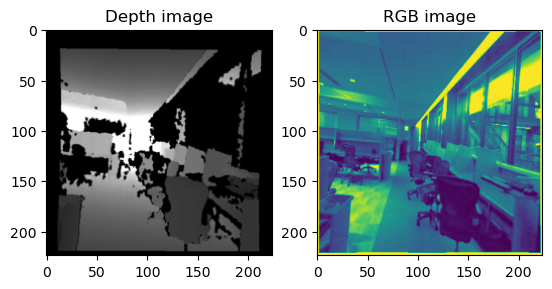

In [132]:
import matplotlib.pyplot as plt

# Get the first batch of data from the DataLoader
rgb, depth = next(iter(depth_dataset))
# depth, rgb = next(iter(depth_dataset))
# depth, rgb = next(iter(depth_dataset)) # get the third batch

# Print the shape of the first batch of depth and RGB images
print("RGB shape:", rgb.shape)

print("Depth shape:", depth.shape)

# Plot the first depth and RGB images in the batch
plt.subplot(1, 2, 1)
plt.imshow(depth[0], cmap='gray')
plt.title("Depth image")
plt.subplot(1, 2, 2)

"""
It looks like the rgb tensor has only two dimensions, 
which is why the permute() operation is failing. 
You can try adding a new dimension to the tensor using the unsqueeze() method before applying the permutation.
"""

plt.imshow(rgb[0].unsqueeze(0).permute(1, 2, 0))
plt.title("RGB image")
plt.show()


# Step 1: Model

Now let's work on our own model. A MLP (Multi-Layer Perceptron, aka Neural Network whose layers are all Linear layers) on the FashinMNIST data set.

We will train out Linear_MLP on the FashinMNIST using consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.

The classes are: 

0	T-shirt/top

1	Trouser

2	Pullover

3	Dress

4	Coat

5	Sandal

6	Shirt

7	Sneaker

8	Bag

9	Ankle boot


Next up is defining the model.

Linear_MLP will have the following architecture:

* There are 4 Fully connected linear layers (which serve as *feature extractors*), followed by 1 linear layers (which serve as the *classifier*).
* All layers have `ReLU` activations. (Use `inplace=True` while defining your ReLUs.)

* For the linear layers, the feature sizes are as follows:

  - $1024 \rightarrow 512 \rightarrow 256 \rightarrow 128 \rightarrow 10$.

  (The 10, of course, is because 10 is the number of classes in FashionMNIST).

In [133]:
class Depth_MLP(torch.nn.Module):
    def __init__(self):
        super(Depth_MLP, self).__init__()
        self.fully_connected_layer_1 = torch.nn.Linear(224 * 224, 1024)
        self.fully_connected_layer_2 = torch.nn.Linear(1024, 512)
        self.fully_connected_layer_3 = torch.nn.Linear(512, 256)
        self.fully_connected_layer_4 = torch.nn.Linear(256, 128)
        self.fully_connected_layer_5 = torch.nn.Linear(128, 224 * 224)  # Output depth map of size 224x224

    def forward(self, image_tensor):
        image_tensor = image_tensor.view(-1, 224 * 224)
        image_tensor = torch.relu(self.fully_connected_layer_1(image_tensor))
        image_tensor = torch.relu(self.fully_connected_layer_2(image_tensor))
        image_tensor = torch.relu(self.fully_connected_layer_3(image_tensor))
        image_tensor = torch.relu(self.fully_connected_layer_4(image_tensor))
        image_tensor = self.fully_connected_layer_5(image_tensor)
        depth_map = image_tensor.view(-1, 1, 224, 224)  # Reshape to depth map with 1 channel
        return depth_map

In [134]:
import torch
import torch.nn as nn
from torchvision.models import resnet18

class DepthResNet(nn.Module):
    def __init__(self):
        super(DepthResNet, self).__init__()
        self.resnet = resnet18(pretrained=True)
        
        # Load the pre-trained ResNet-18 model and modify its first convolutional layer to accept 
        # 3-channel (RGB) images
        # TODO any merit in using single channel (grayscale images)?
        # self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.resnet.conv1 = nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        
        # Remove the fully connected layer (also called the classification head) from the original 
        # ResNet-18 model since we're going to replace it with our custom depth estimation layers
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-2])
        
        # Add upsampling and convolutional layers to generate a depth map with the same spatial dimensions 
        # as the input image. We use nn.Upsample with bilinear interpolation to upscale the feature maps 
        # and a series of convolutional layers with 3x3 kernels and padding to maintain spatial dimensions
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv1 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(32, 1, kernel_size=3, padding=1)

    def forward(self, x):
        # Perform upsampling and pass the output through the custom convolutional layers to 
        # generate the depth map. The upsampling layers increase the spatial dimensions of the 
        # feature maps, while the convolutional layers process the features
        x = self.resnet(x)
        x = self.upsample(x) # becomes 
        x = self.conv1(x)
        x = self.upsample(x)
        x = self.conv2(x)
        x = self.upsample(x)
        x = self.conv3(x)
        x = self.upsample(x)
        x = self.conv4(x)
        x = self.upsample(x)
        x = self.conv5(x)
        return x

In [135]:
resnet_model = DepthResNet()

# Check the model architecture
print(resnet_model)


DepthResNet(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

c:\Users\gaura\.conda\envs\robot_vision_class\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\gaura\.conda\envs\robot_vision_class\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [136]:
# Iterate over the DataLoader object to get batches of data for training the model
for rgb, depth in train_dataloader:
    # TODO train the model
    ...

In [137]:
import torch.optim as optim

# Check if a GPU is available and use it if possible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Move the model to the device
model = DepthResNet().to(device)

# Set up the loss function and the optimizer
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Set the number of training epochs
num_epochs = 20

# Gradient accumulation steps
accumulation_steps = 4

# Iterate over the epochs
for epoch in range(num_epochs):
    running_loss = 0.0
    
    # Iterate over the DataLoader object to get batches of data for training the model
    for i, (rgb, depth) in enumerate(train_dataloader):
        # Move the data to the device
        rgb = rgb.to(device)
        depth = depth.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(rgb)
        
        # Compute the loss
        loss = criterion(outputs, depth) / accumulation_steps
        
        # Backward pass
        loss.backward()
        
        # Optimize
        if (i + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
        
        # Print statistics
        running_loss += loss.item() * accumulation_steps
        if i % 10 == 9:  # Print every 10 mini-batches
            print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 10:.4f}")
            running_loss = 0.0

print("Finished training")


Using device: cuda:0
Finished training


In [138]:
def evaluate_model(model, dataloader, device):
    model.eval()
    total_loss = 0.0
    total_samples = 0

    with torch.no_grad():
        for rgb, depth in dataloader:
            rgb = rgb.to(device)
            depth = depth.to(device)

            outputs = model(rgb)
            loss = criterion(outputs, depth)

            total_loss += loss.item() * rgb.size(0)
            total_samples += rgb.size(0)

    return total_loss / total_samples
# Evaluate the model on the validation dataset
val_loss = evaluate_model(model, val_dataloader, device)
print(f"Validation loss: {val_loss:.4f}")

Validation loss: 5569.5273


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


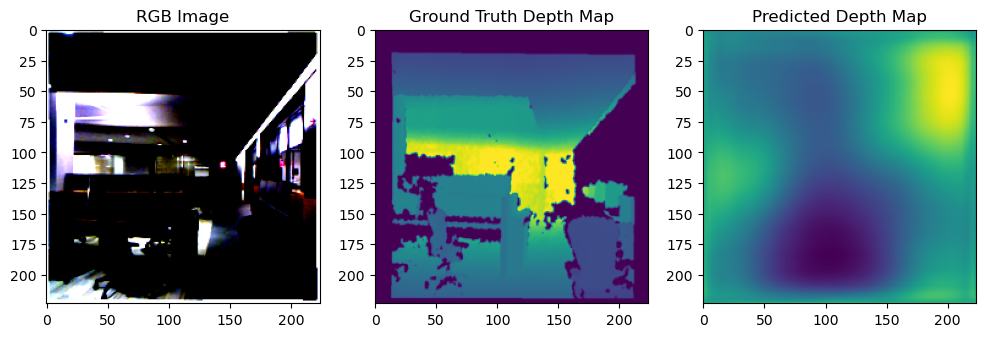

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


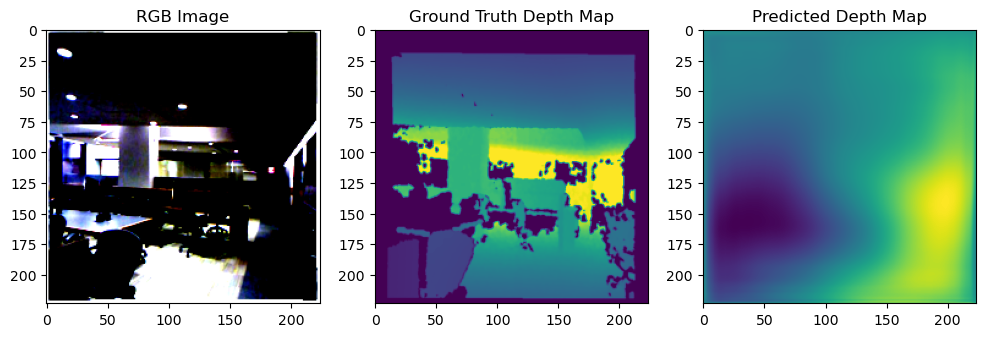

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


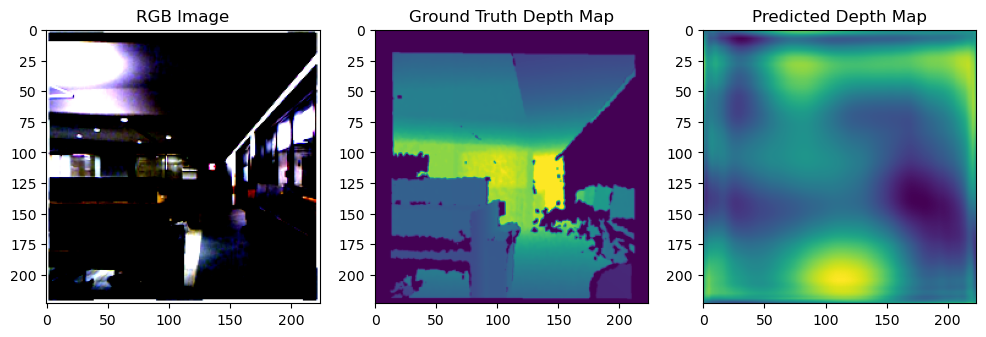

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


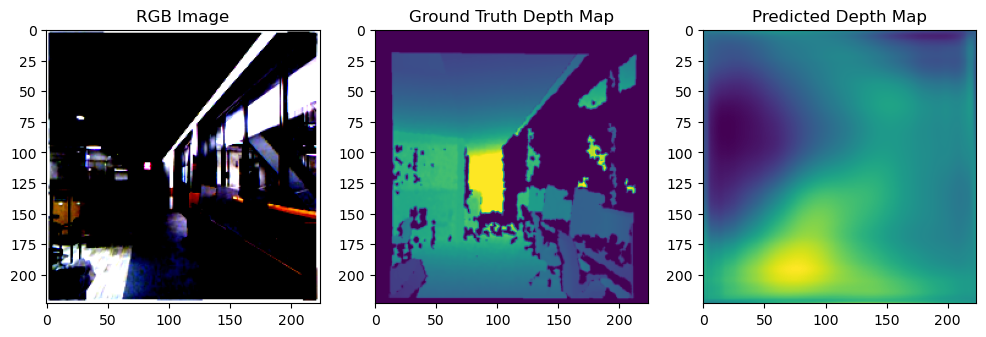

In [139]:
import matplotlib.pyplot as plt

# Set the model to evaluation mode
model.eval()

# Get a batch of data from the validation dataset
rgb_batch, depth_batch = next(iter(val_dataloader))

# Move the batch to the device
rgb_batch = rgb_batch.to(device)

# Predict the depth maps
with torch.no_grad():
    predicted_depth_batch = model(rgb_batch)

# Move the predictions back to the CPU
predicted_depth_batch = predicted_depth_batch.cpu()

# Number of images to visualize
num_images = 4

# Visualize the RGB images, ground truth depth maps, and predicted depth maps
for i in range(num_images):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

    # Display the RGB image
    ax1.imshow(rgb_batch[i].permute(1, 2, 0).cpu().numpy())
    ax1.set_title("RGB Image")

    # Display the ground truth depth map
    ax2.imshow(depth_batch[i].squeeze().cpu().numpy(), cmap="viridis")
    ax2.set_title("Ground Truth Depth Map")

    # Display the predicted depth map
    ax3.imshow(predicted_depth_batch[i].squeeze().cpu().numpy(), cmap="viridis")
    ax3.set_title("Predicted Depth Map")

    plt.show()


Next steps to follow are:

Define your neural network architecture for monocular depth estimation. You can use existing models like U-Net, ResNet, DenseNet, or EfficientNet as your backbone. Make sure you adapt the model to output a single-channel depth map with the same spatial dimensions as the input image.

Define the loss function, which is typically a combination of scale-invariant Mean Squared Error and gradient loss. You can also experiment with other loss functions, like depth-wise L1 loss or BerHu loss.

Set up an optimizer for the model, such as the Adam optimizer or stochastic gradient descent (SGD).

Set up a training loop that iterates over the DataLoader object and performs backpropagation on the model using the loss function and optimizer.

Optionally, set up a validation loop to monitor the model's performance on a separate validation dataset.